# Pairwise statistical tests


### Summary
* What is checked in this notebook
  * 13 models are (pairwise) compared for 2-5 steps compositional tasks:
    - '125M_gpt3_setting',
    - '1.3B_gpt3_setting',
    - '2.7B_gpt3_setting',
    - '6.7B_gpt3_setting',
    - '13B_gpt3_setting',
    - '175B_gpt3_setting__last',
    - 'flan_minus_sentiment_13B',
    - 'flan_minus_sentiment_6.7B',
    - 'huggingface_bigscience=T0pp',
    - 'openai_curie',
    - 'openai_curie-instruct-beta-v2',
    - 'openai_davinci-instruct-beta-v3'
  * The current eval metric (accuracy) and iterative BT scores are used for ranking and summarize model performance
  * Significance test are applied to the pairwise comparision with accuracy and paired BT scores
* Result
  * About half of the models ranked by accuracy and BT score are consistent by ranking, especially for the highest and lowest performed models.
  * ~88% of model pairs have the same levels of proportional significance test result when comparing the pairwise result based on BT with that based on accuracy, which suggests the results based on both metrics are roughly consistent.
  * But among the ~12% pairs of models that the differences are subtle (detected as insignificantly different), only ~13% of them are suggested by both test results, which suggests the results are not consistent in detecting paired models' differences when their performances are relatively close.
* Recommendation
  * Keep using accuracy as the current main metric.
  * Use proportional test to compare pairwise systems' accuracy for significance of test.
  * Iterative BT scores provide a second metric when comparing multiple models' performance on the same task, which helps check whether the pairwise differences are significant or not, especially when they are relatively small.
  * Conduct further analysis on the metrics in the future.

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import average_precision_score, roc_auc_score
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
from pairformance.bt import BT as BT2  # optional for validation

from examples.few_shot.scripts.significance_test import (
    power_p_test_2sample,
    power_t_test,
    power_t_test_2sample,
    power_bt_test_2sample,
    BT,
)

cmap_green_yellow_red = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['green','yellow','red']
)

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.set_loglevel("error")
pd.options.display.max_colwidth = None

In [2]:
from examples.few_shot.scripts.collect_results import (
    load_results,
    get_predictions_gold_probability_for_results_file
)

In [3]:
def calc_1pair_bt(scores1, scores2):
    comp = (np.array(scores1) - np.array(scores2)) > 0
    return np.sum(comp) / len(comp)

def calc_accuracy(target, labels):
    return np.sum(labels == target) / len(labels)

def calc_avg_precision(target, scores):
    return average_precision_score(target, scores)

def calc_paired_accuracy(y, labels1, labels2):
    return np.sum(labels1 == y) / len(labels1), np.sum(labels2 == y) / len(labels2)

def load_predictions(results_file):
    prediction_gold_scores_correct = get_predictions_gold_probability_for_results_file(
        results_file,
        soft_scores=False,
        ensemble="mean"
    )

    prediction_gold_scores_correct_soft = get_predictions_gold_probability_for_results_file(
        results_file,
        soft_scores=True,
        ensemble="mean"
    )
    return prediction_gold_scores_correct[0], prediction_gold_scores_correct_soft[0]

def cal_significance(scores1, scores2, accuracy1, accuracy2, alternative="two-sided"):
    test1 = power_bt_test_2sample(
        scores1=np.array(scores1), scores2=np.array(scores2), power=0.9, sig_level=None, alternative=alternative
    )
    test2 = power_p_test_2sample(
        n1=len(scores1), n2=len(scores2), p1=accuracy1, p2=accuracy2, power=0.9, sig_level=None, alternative=alternative
    )
    return test1[0],test2[0], test1[1], test2[1]



## Load data
* Tasks
XLM-G (13B)
XLM-G+FLAN (13B)
T0pp (11B)
OpenAI-Curie (~13B)
OpenAI-Curie-Instruct (~13B)
XLM-G (175B)
* Task
wiki40b-val-fact-500-docs-comp-4
* Template
cic_v4_simple

In [4]:
results_raw_jsonl_list = [
    "/large_experiments/xlmg/data/results/compositional_instructions/main/20220203-1.1/results.tsv.raw.jsonl"
]

all_results = []
for results_raw_file in results_raw_jsonl_list:
    results, expanded_results, current_tasks_to_groups  = load_results(results_raw_file)
    all_results.extend(results)

results = all_results
print(f"{len(results)} loaded")


137 loaded


In [5]:
cols = ["task", "language", "eval_examples_cnt", "eval_set", "train_set", 
        "train_lang", "nb_few_shot_samples", "calibration", "template",
        "model_name", "_metric_val", "_metric_val_std", "results_file"]
df1 = pd.DataFrame(results)[cols]
display(df1.shape, df1.head())

(137, 13)

,task,language,eval_examples_cnt,eval_set,train_set,train_lang,nb_few_shot_samples,calibration,template,model_name,_metric_val,_metric_val_std,results_file
0,cic_v1_1_comp_subtasks,en,8740,wiki40b-val-fact-500-docs-comp-5,wiki40b-val-fact-500-docs-comp-2,en,0,False,cic_v3_with_complex_subtasks,random,0.032037,0.0,/large_experiments/xlmg/results/compositional_benchmark_results/cic_v1_1/cic_v1_1_comp_subtasks_steps5_random_fs.0_t5_smpl.All_current/task.cic_v1_1_comp_subtasks_tmp.cic_v3_with_complex_subtasks_train.wiki40b-val-fact-500-docs-comp-2.en_val.None.en_eval.wiki40b-val-fact-500-docs-comp-5.en_calib.None_fs0_results.json
1,cic_v1_1_comp_subtasks,en,8740,wiki40b-val-fact-500-docs-comp-5,wiki40b-val-fact-500-docs-comp-2,en,0,False,cic_v4_simple,random,4.462243,0.0,/large_experiments/xlmg/results/compositional_benchmark_results/cic_v1_1/cic_v1_1_comp_subtasks_steps5_random_fs.0_t5_smpl.All_current/task.cic_v1_1_comp_subtasks_tmp.cic_v4_simple_train.wiki40b-val-fact-500-docs-comp-2.en_val.None.en_eval.wiki40b-val-fact-500-docs-comp-5.en_calib.None_fs0_results.json
2,cic_v1_1_comp_subtasks,en,8740,wiki40b-val-fact-500-docs-comp-5,wiki40b-val-fact-500-docs-comp-2,en,0,False,cic_v4_simple_negated,random,4.118993,0.0,/large_experiments/xlmg/results/compositional_benchmark_results/cic_v1_1/cic_v1_1_comp_subtasks_steps5_random_fs.0_t5_smpl.All_current/task.cic_v1_1_comp_subtasks_tmp.cic_v4_simple_negated_train.wiki40b-val-fact-500-docs-comp-2.en_val.None.en_eval.wiki40b-val-fact-500-docs-comp-5.en_calib.None_fs0_results.json
3,cic_v1_1_comp_subtasks,en,5244,wiki40b-val-fact-500-docs-comp-3,wiki40b-val-fact-500-docs-comp-2,en,0,False,cic_v4_simple,175B_gpt3_setting__last,41.189931,0.0,/large_experiments/xlmg/results/compositional_benchmark_results/cic_v1_1/cic_v1_1_comp_subtasks_steps3_175B_gpt3_setting__last_fs.0_t5_smpl.All_current/task.cic_v1_1_comp_subtasks_tmp.cic_v4_simple_train.wiki40b-val-fact-500-docs-comp-2.en_val.None.en_eval.wiki40b-val-fact-500-docs-comp-3.en_calib.None_fs0_results.json
4,cic_v1_1_comp_subtasks,en,5244,wiki40b-val-fact-500-docs-comp-3,wiki40b-val-fact-500-docs-comp-2,en,0,False,cic_v4_simple_negated,175B_gpt3_setting__last,17.219680,0.0,/large_experiments/xlmg/results/compositional_benchmark_results/cic_v1_1/cic_v1_1_comp_subtasks_steps3_175B_gpt3_setting__last_fs.0_t5_smpl.All_current/task.cic_v1_1_comp_subtasks_tmp.cic_v4_simple_negated_train.wiki40b-val-fact-500-docs-comp-2.en_val.None.en_eval.wiki40b-val-fact-500-docs-comp-3.en_calib.None_fs0_results.json


In [6]:
df1 = df1[df1.eval_examples_cnt > 200]
display(df1.groupby(["task"]).count()[["_metric_val"]].reset_index())
display(df1.groupby(["eval_set", "eval_examples_cnt"]).count()[["_metric_val"]].reset_index())
display(df1.groupby(["template"]).count()[["_metric_val"]].reset_index())
display(df1.groupby(["model_name"]).count()[["_metric_val"]].reset_index())


,task,_metric_val
0,cic_v1_1_comp_subtasks,136


,eval_set,eval_examples_cnt,_metric_val
0,wiki40b-val-fact-500-docs-comp-2,3496,34
1,wiki40b-val-fact-500-docs-comp-3,5244,34
2,wiki40b-val-fact-500-docs-comp-4,6992,34
3,wiki40b-val-fact-500-docs-comp-5,8740,34


,template,_metric_val
0,cic_v3_with_complex_subtasks,24
1,cic_v3_with_complex_subtasks_flanformat,4
2,cic_v4_simple,44
3,cic_v4_simple_flanformat,12
4,cic_v4_simple_flanformat_negated,8
5,cic_v4_simple_negated,44


,model_name,_metric_val
0,1.3B_gpt3_setting,12
1,125M_gpt3_setting,12
2,13B_gpt3_setting,12
3,175B_gpt3_setting__last,8
4,2.7B_gpt3_setting,12
5,6.7B_gpt3_setting,8
6,flan_minus_sentiment_13B,16
7,flan_minus_sentiment_6.7B,8
8,huggingface_bigscience=T0pp,8
9,majority,4


In [7]:
df2 = df1[(df1.template == 'cic_v4_simple') | (df1.template == 'cic_v4_simple_flanformat')]
df2 = df2[~((df2.model_name == "flan_minus_sentiment_13B") & (df2["results_file"].str.contains("0_t5_smpl_fixed")))]

display(df2.groupby(["eval_set", "template"]).count()[["_metric_val"]].unstack())
display(df2.groupby(["template"]).count()[["_metric_val"]].reset_index())
display(df2.groupby(["model_name"]).count()[["_metric_val"]].reset_index())

_metric_val                         
template                         cic_v4_simple cic_v4_simple_flanformat
eval_set                                                               
wiki40b-val-fact-500-docs-comp-2            11                        2
wiki40b-val-fact-500-docs-comp-3            11                        2
wiki40b-val-fact-500-docs-comp-4            11                        2
wiki40b-val-fact-500-docs-comp-5            11                        2

,template,_metric_val
0,cic_v4_simple,44
1,cic_v4_simple_flanformat,8


,model_name,_metric_val
0,1.3B_gpt3_setting,4
1,125M_gpt3_setting,4
2,13B_gpt3_setting,4
3,175B_gpt3_setting__last,4
4,2.7B_gpt3_setting,4
5,6.7B_gpt3_setting,4
6,flan_minus_sentiment_13B,4
7,flan_minus_sentiment_6.7B,4
8,huggingface_bigscience=T0pp,4
9,openai_curie,4


In [8]:
display(df2.groupby(["model_name", "eval_set"]).count()[["_metric_val"]].unstack())

_metric_val  \
eval_set                        wiki40b-val-fact-500-docs-comp-2   
model_name                                                         
1.3B_gpt3_setting                                              1   
125M_gpt3_setting                                              1   
13B_gpt3_setting                                               1   
175B_gpt3_setting__last                                        1   
2.7B_gpt3_setting                                              1   
6.7B_gpt3_setting                                              1   
flan_minus_sentiment_13B                                       1   
flan_minus_sentiment_6.7B                                      1   
huggingface_bigscience=T0pp                                    1   
openai_curie                                                   1   
openai_curie-instruct-beta-v2                                  1   
openai_davinci-instruct-beta-v3                                1   
random                                                         1   

                                                                  \
eval_set                        wiki40b-val-fact-500-docs-comp-3   
model_name                                                         
1.3B_gpt3_setting                                              1   
125M_gpt3_setting                                              1   
13B_gpt3_setting                                               1   
175B_gpt3_setting__last                                        1   
2.7B_gpt3_setting                                              1   
6.7B_gpt3_setting                                              1   
flan_minus_sentiment_13B                                       1   
flan_minus_sentiment_6.7B                                      1   
huggingface_bigscience=T0pp                                    1   
openai_curie                                                   1   
openai_curie-instruct-beta-v2                                  1   
openai_davinci-instruct-beta-v3                                1   
random                                                         1   

                                                                  \
eval_set                        wiki40b-val-fact-500-docs-comp-4   
model_name                                                         
1.3B_gpt3_setting                                              1   
125M_gpt3_setting                                              1   
13B_gpt3_setting                                               1   
175B_gpt3_setting__last                                        1   
2.7B_gpt3_setting                                              1   
6.7B_gpt3_setting                                              1   
flan_minus_sentiment_13B                                       1   
flan_minus_sentiment_6.7B                                      1   
huggingface_bigscience=T0pp                                    1   
openai_curie                                                   1   
openai_curie-instruct-beta-v2                                  1   
openai_davinci-instruct-beta-v3                                1   
random                                                         1   

                                                                  
eval_set                        wiki40b-val-fact-500-docs-comp-5  
model_name                                                        
1.3B_gpt3_setting                                              1  
125M_gpt3_setting                                              1  
13B_gpt3_setting                                               1  
175B_gpt3_setting__last                                        1  
2.7B_gpt3_setting                                              1  
6.7B_gpt3_setting                                              1  
flan_minus_sentiment_13B                                       1  
flan_minus_sentiment_6.7B                                      1  
huggingface_bigscience=T0pp                      

In [9]:
df2 = df2[df2.model_name != "random"]
df2.reset_index(drop=True, inplace=True)
df2.shape

(48, 13)

## Check the consistency among BT and accuracy and predictions distribution

### Example of 2-step eval_set

In [10]:
predictions = {}
for index, row in df2.iterrows():
    if row.eval_set != "wiki40b-val-fact-500-docs-comp-2":
        continue
    try:
        _, scores = load_predictions(row.results_file)
        predictions[row.model_name] = scores
    except Exception as e:
        print(i, row.model_name, row.eval_set)
        print(row.results_file)
        print(str(e))
        print()
        continue
    
# predictions.keys()

In [11]:
df_preds = pd.DataFrame(predictions)

df3 = df2[df2.eval_set == "wiki40b-val-fact-500-docs-comp-2"]
del df3["results_file"]
df3["bt"] = BT(df_preds)

print("bt sorted:")
print(df3.sort_values(by=["bt"]).index)
# print(df3.sort_values(by=["bt"]).model_name)

print("_metric_val sorted:")
print(df3.sort_values(by=["_metric_val"]).index)
# print(df3.sort_values(by=["_metric_val"]).model_name)

bt sorted:
Int64Index([24, 13, 26, 40, 12, 25, 5, 44, 23, 6, 27, 16], dtype='int64')
_metric_val sorted:
Int64Index([24, 13, 40, 25, 26, 27, 12, 5, 44, 23, 6, 16], dtype='int64')


In [12]:
print("BT scores by native function:")
print(BT(df_preds))
print("BT scores by pairformance function:")
print(BT2(df_preds))

BT scores by native function:
[0.08068625 0.1095288  0.07373329 0.05753903 0.12836597 0.09698447
 0.04962663 0.07850621 0.0601185  0.11214217 0.06180858 0.09096012]
BT scores by pairformance function:
[0.0806846  0.10952681 0.07373243 0.0575393  0.12836906 0.09698017
 0.04962637 0.07850587 0.06011897 0.11214611 0.06180879 0.09096152]


In [13]:
print("rank models by BT for 2-step compositional eval set:")
df3.sort_values(by=["bt"]).model_name.to_list()

rank models by BT for 2-step compositional eval set:


['flan_minus_sentiment_13B',
 '1.3B_gpt3_setting',
 'openai_curie',
 'flan_minus_sentiment_6.7B',
 '175B_gpt3_setting__last',
 'openai_curie-instruct-beta-v2',
 '125M_gpt3_setting',
 'huggingface_bigscience=T0pp',
 '2.7B_gpt3_setting',
 '13B_gpt3_setting',
 'openai_davinci-instruct-beta-v3',
 '6.7B_gpt3_setting']

In [14]:
print("rank models by accuracy for 2-step compositional eval set:")
df3.sort_values(by=["_metric_val"]).model_name.to_list()

rank models by accuracy for 2-step compositional eval set:


['flan_minus_sentiment_13B',
 '1.3B_gpt3_setting',
 'flan_minus_sentiment_6.7B',
 'openai_curie-instruct-beta-v2',
 'openai_curie',
 'openai_davinci-instruct-beta-v3',
 '175B_gpt3_setting__last',
 '125M_gpt3_setting',
 'huggingface_bigscience=T0pp',
 '2.7B_gpt3_setting',
 '13B_gpt3_setting',
 '6.7B_gpt3_setting']

In [15]:
acct_sorted_models = np.array(df3.sort_values(by=["_metric_val"]).model_name)
bt_sorted_models = np.array(df3.sort_values(by=["bt"]).model_name)

similar_ranks = np.sum(acct_sorted_models == bt_sorted_models) + \
    np.sum(acct_sorted_models[1:] == bt_sorted_models[:-1]) + \
    np.sum(acct_sorted_models[:-1] == bt_sorted_models[1:])

print(f'{similar_ranks} out of {df3.shape[0]} models have similar orders when ranked by accuracy vs ranked by BT score')


8 out of 12 models have similar orders when ranked by accuracy vs ranked by BT score


,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
125M_gpt3_setting,3496.0,0.591524,0.303835,0.010408,0.295637,0.697609,0.857768,0.992934
13B_gpt3_setting,3496.0,0.632753,0.386664,0.002099,0.139396,0.855851,0.951863,0.999333
175B_gpt3_setting__last,3496.0,0.578467,0.270676,0.017177,0.339828,0.637031,0.815233,0.991084
1.3B_gpt3_setting,3496.0,0.516836,0.228667,0.028653,0.334589,0.519521,0.699254,0.982490
6.7B_gpt3_setting,3496.0,0.652247,0.426636,0.000145,0.061539,0.931960,0.978875,0.999866
2.7B_gpt3_setting,3496.0,0.620558,0.347318,0.003260,0.226784,0.795022,0.911810,0.998252
flan_minus_sentiment_13B,3496.0,0.497489,0.028348,0.041527,0.499834,0.499991,0.500080,0.839133
openai_curie-instruct-beta-v2,3496.0,0.563787,0.363172,0.000028,0.180226,0.643489,0.925486,0.999978
openai_curie,3496.0,0.538644,0.194625,0.030816,0.395305,0.546658,0.689324,0.966280


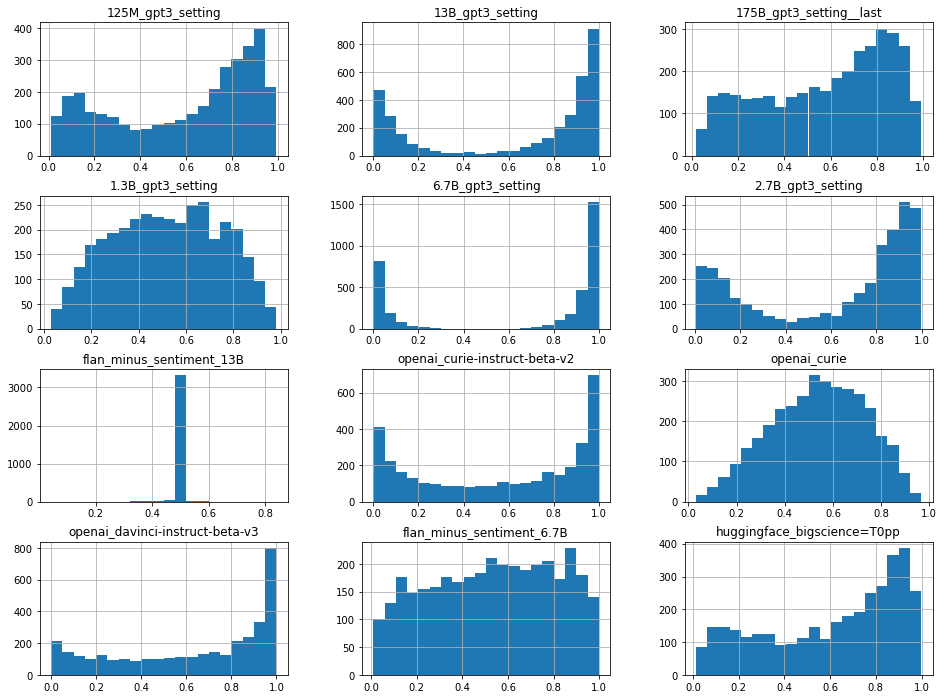

In [16]:
df4 = pd.DataFrame(predictions, columns=df3.model_name)
display(df4.describe().T)
_ = df4.hist(figsize=(16, 12), bins=20)

## Plot pairwise comparison for all compositional tasks

In [17]:
def load_predictions_and_bt_for_eval_set(df):
    df_set, pred_set = {}, {}
    for eval_set in df.eval_set.drop_duplicates():
        predictions = {}
        for index, row in df.iterrows():
            if row.eval_set != eval_set:
                continue
            _, scores = load_predictions(row.results_file)
            predictions[row.model_name] = scores

        df_preds = pd.DataFrame(predictions)
        pred_set[eval_set] = df_preds

        df3 = df[df.eval_set == eval_set]
        df3["bt"] = BT(df_preds)
        df_set[eval_set] = df3
    return df_set, pred_set

In [18]:
def compute_stats(df0, df_preds, sort_by="bt"):
    df = df0.sort_values(by=[sort_by])
    results_bt = [[0.5] * df.shape[0] for i in range(df.shape[0])]
    sig_bt = [[1] * df.shape[0] for i in range(df.shape[0])]
    sig_pt = [[1] * df.shape[0] for i in range(df.shape[0])]

    for i, row in df.reset_index().iterrows():
        for j, col in df.reset_index().iterrows():
            if i <= j:
                continue
            bt = BT(df_preds[[row.model_name, col.model_name]])

            alternative = "larger" if bt[0] > 0.5 else "smaller"
            sig1, msg1 = power_bt_test_2sample(
                scores1=df_preds[row.model_name], scores2=df_preds[col.model_name], power=0.9, sig_level=None, alternative=alternative
            )

            alternative = "larger" if row._metric_val > col._metric_val else "smaller"
            sig2, msg2 = power_p_test_2sample(
                n1=df_preds.shape[0], n2=df_preds.shape[0], p1=row._metric_val/100, p2=col._metric_val/100, power=0.9, sig_level=None, alternative=alternative
            )

            sig_bt[i][j], sig_bt[j][i] = round(sig1, 6), round(sig1, 6)
            sig_pt[i][j], sig_pt[j][i] = round(sig2, 6), round(sig2, 6)

            results_bt[i][j], results_bt[j][i] = bt[0], bt[1]

    return {"bt": results_bt, "bt_sig": sig_bt, "accu_sig": sig_pt}


In [19]:
df_set, pred_set = load_predictions_and_bt_for_eval_set(df2)

result_bt_set, result_accu_set = {}, {}
for eval_set in df_set:
    result_bt_set[eval_set] = compute_stats(df_set[eval_set], pred_set[eval_set], "bt")
    result_accu_set[eval_set] = compute_stats(df_set[eval_set], pred_set[eval_set], "_metric_val")


## models ranked by BT
### pairwise BT scores (models ranked by BT)
* Any cell value > 0.5 suggests the model labeled by the row index performs better than that labeled by the column index

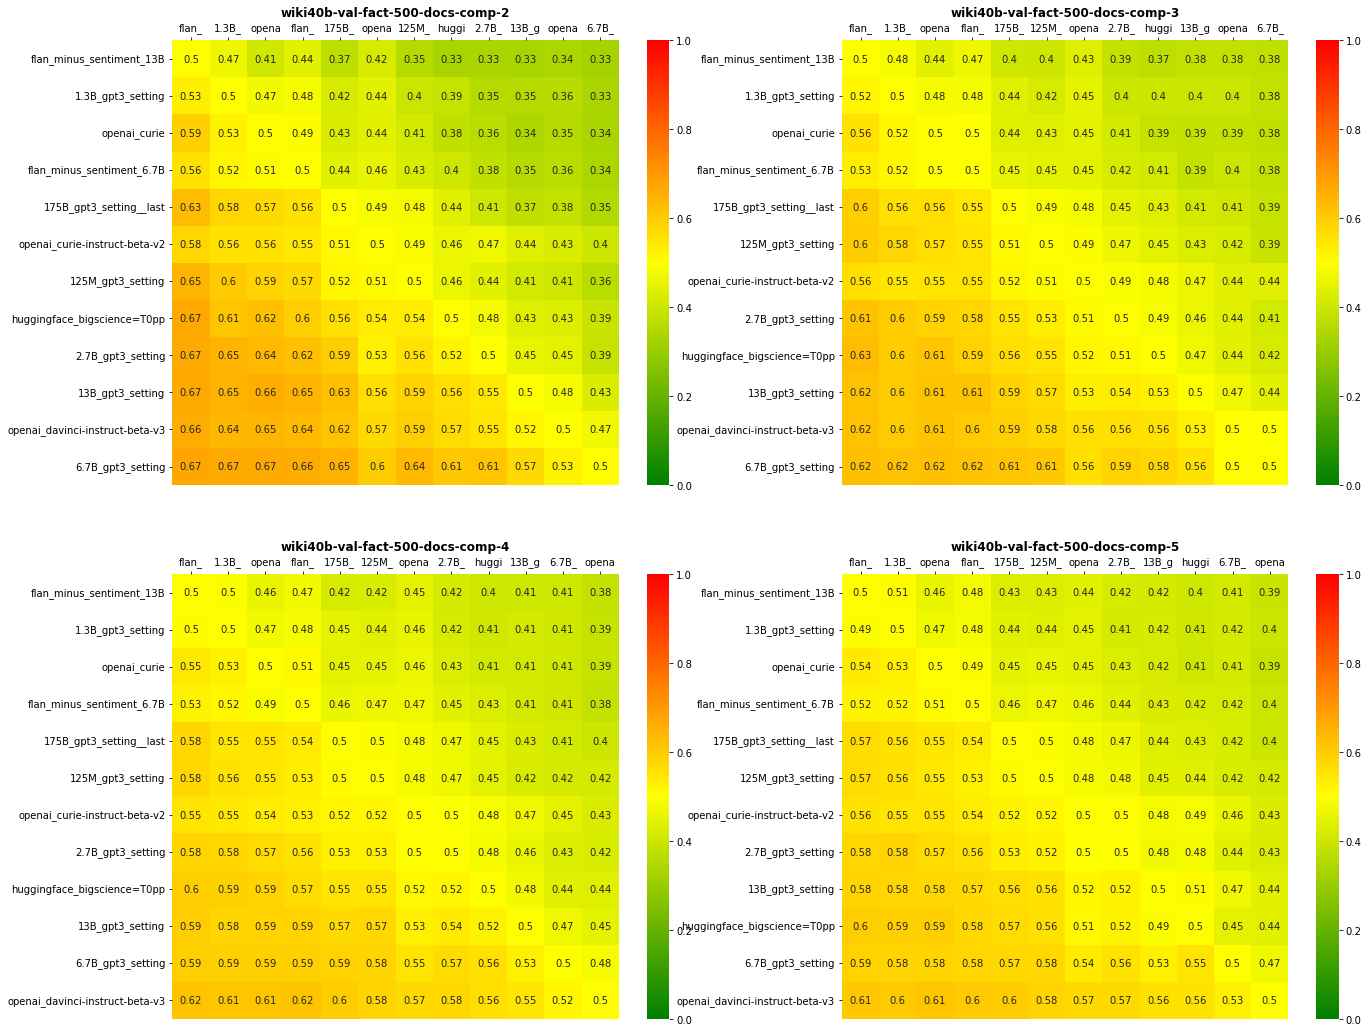

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(22, 18))

for i, key in enumerate(np.sort(list(result_bt_set.keys()))):
    model_names = df_set[key].sort_values(by=["bt"]).model_name.to_list()
    sns.heatmap(
        np.around(result_bt_set[key]["bt"], 3),
        xticklabels=[x[:5] for x in model_names],  # shorter label name
        yticklabels=model_names,
        vmin=0.00,
        vmax=1,
        annot=True,
        cmap=cmap_green_yellow_red,
        ax=axs[i // 2, i % 2],
    )
#     ax.tick_params(axis='x', rotation=60)
    axs[i // 2, i % 2].xaxis.tick_top()
    axs[i // 2, i % 2].xaxis.set_label_position('top')
    axs[i // 2, i % 2].set_title(key, weight='bold')
    
plt.show()

### proportional significance test for pairwise BT scores (models ranked by BT score)
* any cell value <0.1 suggest the pairwise proportional test is significant

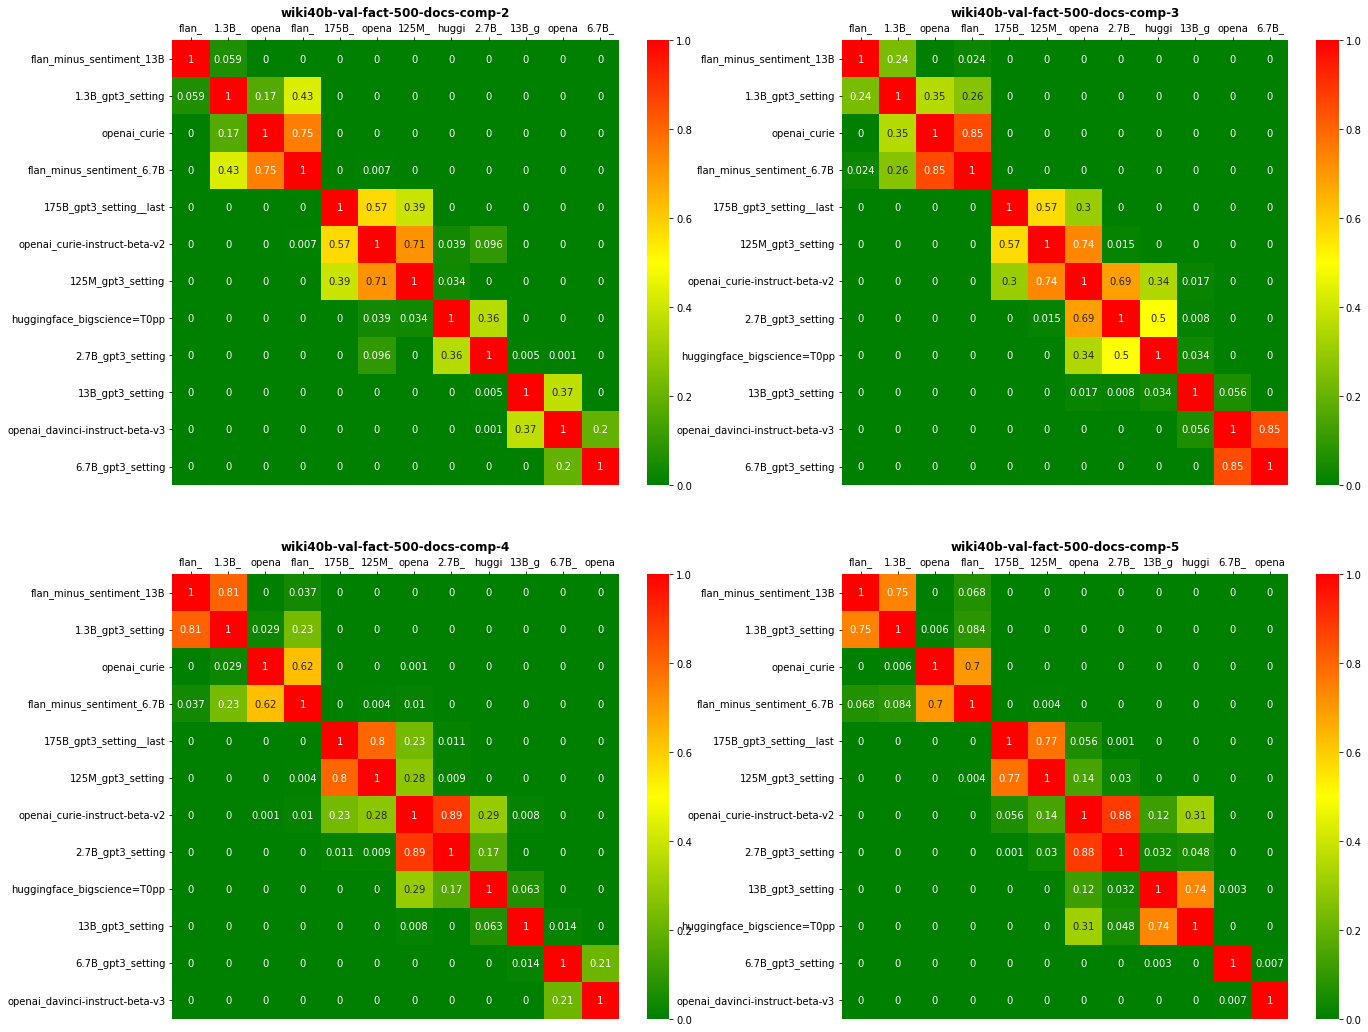

In [21]:
plt.set_loglevel("error")

fig, axs = plt.subplots(2, 2, figsize=(22, 18))

for i, key in enumerate(np.sort(list(result_bt_set.keys()))):
    model_names = df_set[key].sort_values(by=["bt"]).model_name.to_list()
    sns.heatmap(
        np.around(result_bt_set[key]["bt_sig"], 3),
        xticklabels=[x[:5] for x in model_names],  # shorter label name
        yticklabels=model_names,
        vmin=0.00,
        vmax=1,
        annot=True,
        cmap=cmap_green_yellow_red,
        ax=axs[i // 2, i % 2],
    )
#     ax.tick_params(axis='x', rotation=60)
    axs[i // 2, i % 2].xaxis.tick_top()
    axs[i // 2, i % 2].xaxis.set_label_position('top')
    axs[i // 2, i % 2].set_title(key, weight='bold')
    
plt.show()

## models ranked by accuracy
###  proportional significance test for pairwise accuracy (models ranked by accuracy)
* any cell value <0.1 suggest the pairwise proportional test is significant

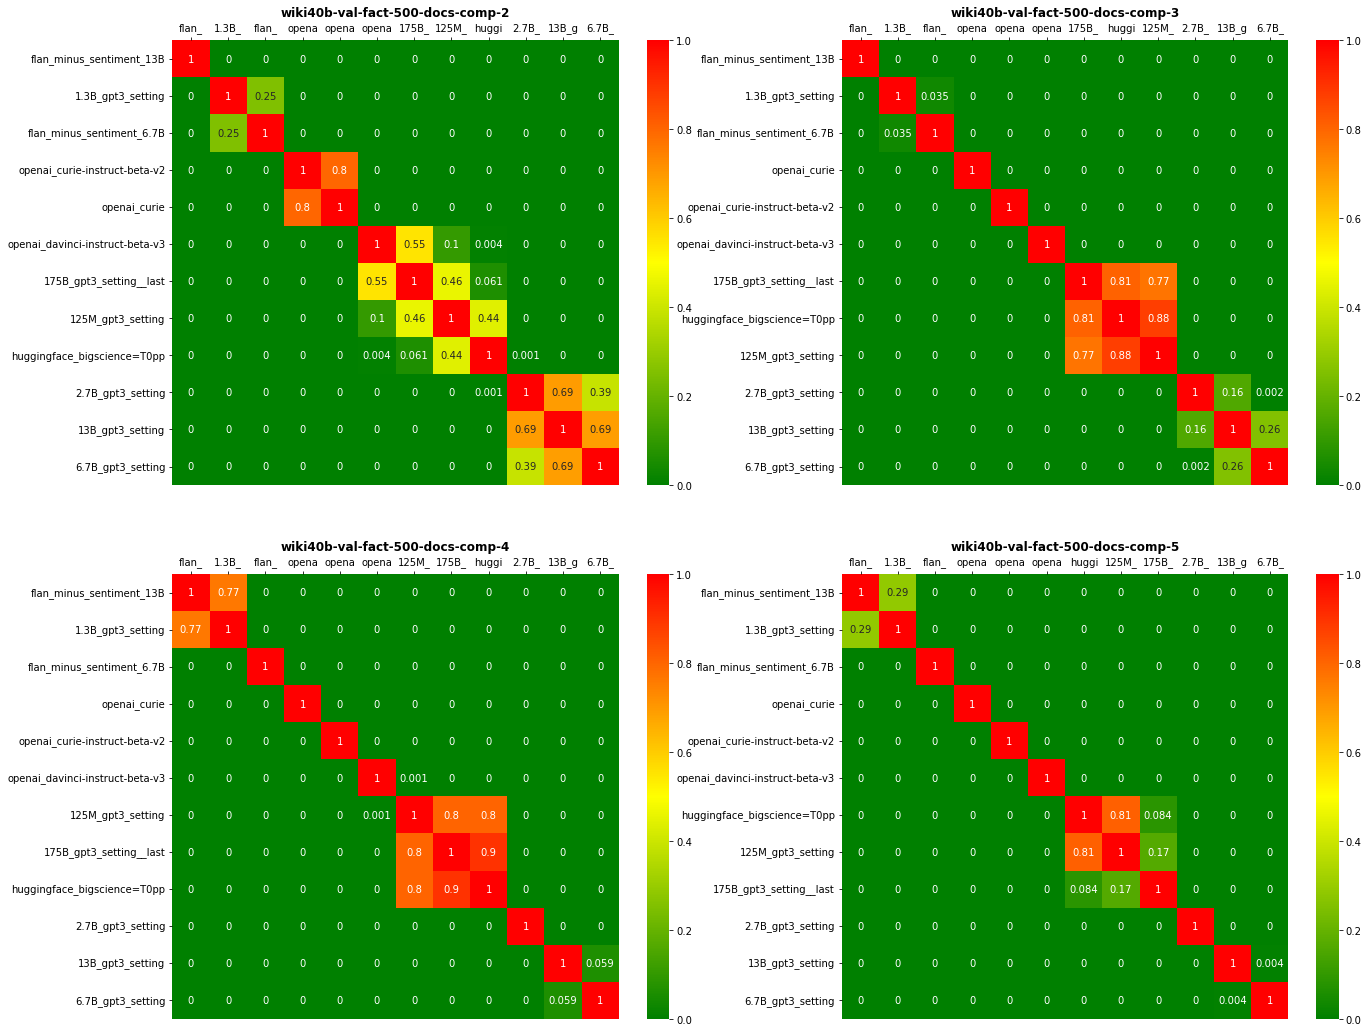

In [22]:
plt.set_loglevel("error")

fig, axs = plt.subplots(2, 2, figsize=(22, 18))

for i, key in enumerate(np.sort(list(result_bt_set.keys()))):
    model_names = df_set[key].sort_values(by=["_metric_val"]).model_name.to_list()
    sns.heatmap(
        np.around(result_accu_set[key]["accu_sig"], 3),
        xticklabels=[x[:5] for x in model_names],  # shorter label name
        yticklabels=model_names,
        vmin=0.00,
        vmax=1,
        annot=True,
        cmap=cmap_green_yellow_red,
        ax=axs[i // 2, i % 2],
    )
#     ax.tick_params(axis='x', rotation=60)
    axs[i // 2, i % 2].xaxis.tick_top()
    axs[i // 2, i % 2].xaxis.set_label_position('top')
    axs[i // 2, i % 2].set_title(key, weight='bold')
    
plt.show()

### pairwise BT (models ranked by accuracy)
* Any cell value > 0.5 suggests the model labeled by the row index performs better than that labeled by the column index

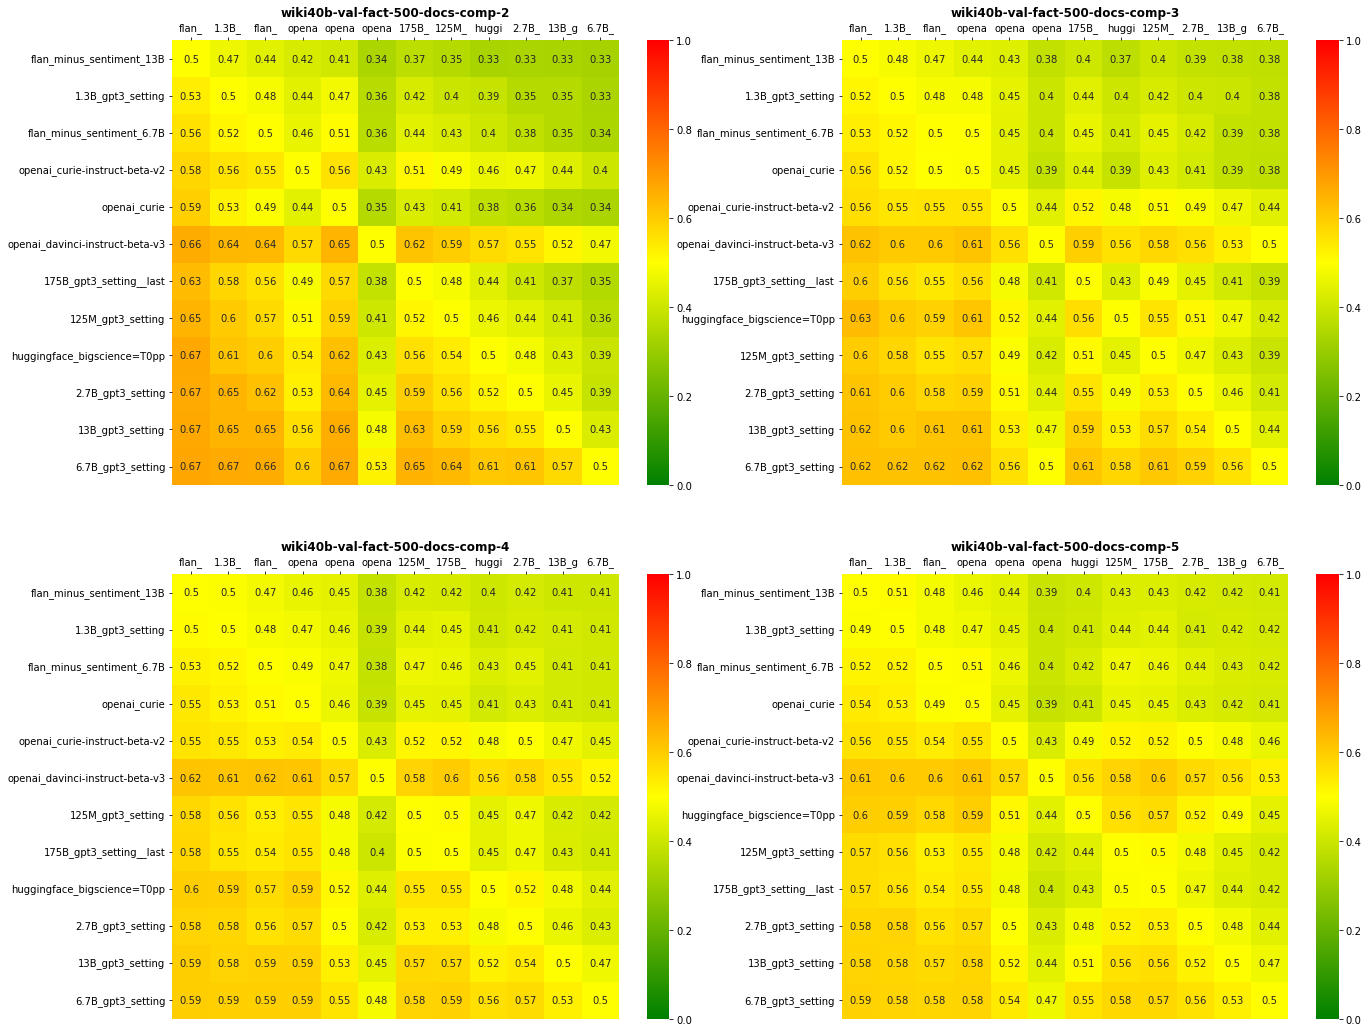

In [23]:
plt.set_loglevel("error")

fig, axs = plt.subplots(2, 2, figsize=(22, 18))

for i, key in enumerate(np.sort(list(result_bt_set.keys()))):
    model_names = df_set[key].sort_values(by=["_metric_val"]).model_name.to_list()
    sns.heatmap(
        np.around(result_accu_set[key]["bt"], 3),
        xticklabels=[x[:5] for x in model_names],  # shorter label name
        yticklabels=model_names,
        vmin=0.00,
        vmax=1,
        annot=True,
        cmap=cmap_green_yellow_red,
        ax=axs[i // 2, i % 2],
    )
#     ax.tick_params(axis='x', rotation=60)
    axs[i // 2, i % 2].xaxis.tick_top()
    axs[i // 2, i % 2].xaxis.set_label_position('top')
    axs[i // 2, i % 2].set_title(key, weight='bold')
    
plt.show()

## Debug/Dev: Plot BT pairwise comparison - 2-step compositional task (models are ranked by iterative BT score)

In [24]:
df3 = df3.sort_values(by=["bt"])

results_bt = [[0.5] * df3.shape[0] for i in range(df3.shape[0])]
sig_bt = [[1] * df3.shape[0] for i in range(df3.shape[0])]
sig_pt = [[1] * df3.shape[0] for i in range(df3.shape[0])]

for i, row in df3.reset_index().iterrows():
    for j, col in df3.reset_index().iterrows():
        if i <= j:
            continue
        bt = BT(df_preds[[row.model_name, col.model_name]])

        alternative = "larger" if bt[0] > 0.5 else "smaller"
        sig1, msg1 = power_bt_test_2sample(
            scores1=df_preds[row.model_name], scores2=df_preds[col.model_name], power=0.9, sig_level=None, alternative=alternative
        )
        alternative = "larger" if row._metric_val > col._metric_val else "smaller"
        sig2, msg2 = power_p_test_2sample(
            n1=df_preds.shape[0], n2=df_preds.shape[0], p1=row._metric_val/100, p2=col._metric_val/100, power=0.9, sig_level=None, alternative=alternative
        )
        
        sig_bt[i][j], sig_bt[j][i] = round(sig1, 6), round(sig1, 6)
        sig_pt[i][j], sig_pt[j][i] = round(sig2, 6), round(sig2, 6)

        results_bt[i][j], results_bt[j][i] = bt[0], bt[1]


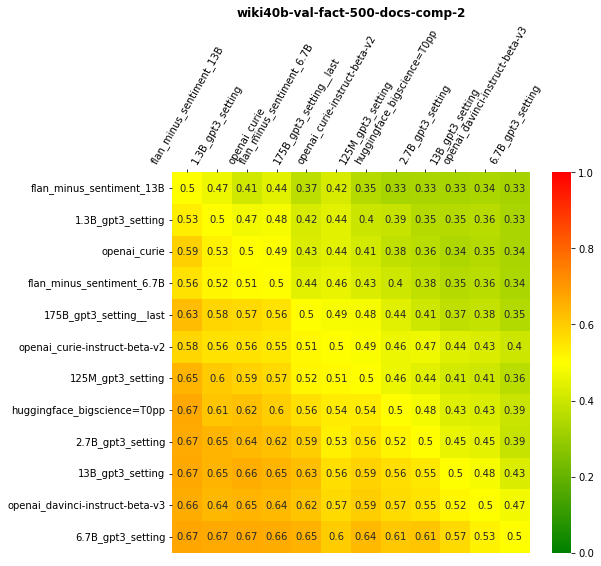

In [25]:
figure(figsize=(8, 7))

significance_matrix = np.around(results_bt, 3)
ax = sns.heatmap(
    significance_matrix, 
#     mask=sig_matrix_mask, 
    xticklabels=df3.model_name.to_list(),
    yticklabels=df3.model_name.to_list(),
    vmin=0.00,
    vmax=1,  # 0.3
    annot=True,
    cmap=cmap_green_yellow_red
)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title(df3.eval_set.to_list()[0], weight='bold')

plt.show()

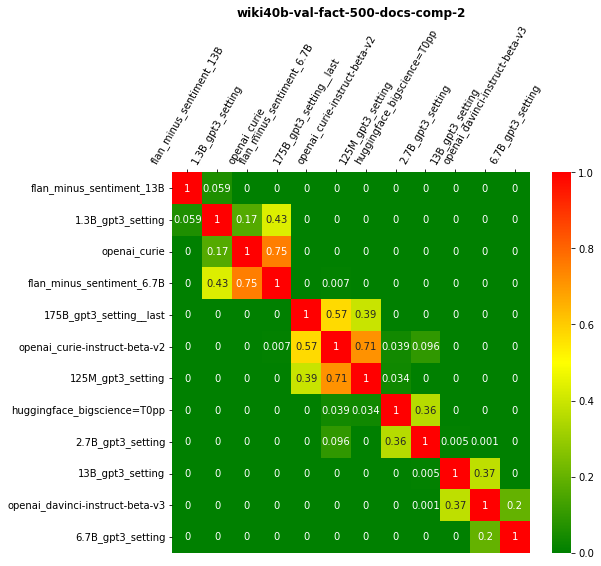

In [26]:
figure(figsize=(8, 7))

significance_matrix = np.around(sig_bt, 3)
ax = sns.heatmap(
    significance_matrix, 
#     mask=sig_matrix_mask, 
    xticklabels=df3.model_name.to_list(),
    yticklabels=df3.model_name.to_list(),
    vmin=0.00,
    vmax=1,  # 0.3
    annot=True,
    cmap=cmap_green_yellow_red
)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title(df3.eval_set.to_list()[0], weight='bold')

plt.show()

In [27]:
np.sum(np.array(sig_bt) > 0.1)

30

## Debug/Dev: Plot accuracy pairwise comparison - 2-step compositional task (models are ranked by accuracy)

In [28]:
df3 = df3.sort_values(by=["_metric_val"])

results_bt = [[0.5] * df3.shape[0] for i in range(df3.shape[0])]
sig_bt = [[1] * df3.shape[0] for i in range(df3.shape[0])]
sig_pt = [[1] * df3.shape[0] for i in range(df3.shape[0])]

for i, row in df3.reset_index().iterrows():
    for j, col in df3.reset_index().iterrows():
        if i <= j:
            continue
        bt = BT(df_preds[[row.model_name, col.model_name]])

        alternative = "larger" if bt[0] > 0.5 else "smaller"
        sig1, msg1 = power_bt_test_2sample(
            scores1=df_preds[row.model_name], scores2=df_preds[col.model_name], power=0.9, sig_level=None, alternative=alternative
        )
        alternative = "larger" if row._metric_val > col._metric_val else "smaller"
        sig2, msg2 = power_p_test_2sample(
            n1=df_preds.shape[0], n2=df_preds.shape[0], p1=row._metric_val/100, p2=col._metric_val/100, power=0.9, sig_level=None, alternative=alternative
        )
        
        sig_bt[i][j], sig_bt[j][i] = round(sig1, 6), round(sig1, 6)
        sig_pt[i][j], sig_pt[j][i] = round(sig2, 6), round(sig2, 6)

        results_bt[i][j], results_bt[j][i] = bt[0], bt[1]


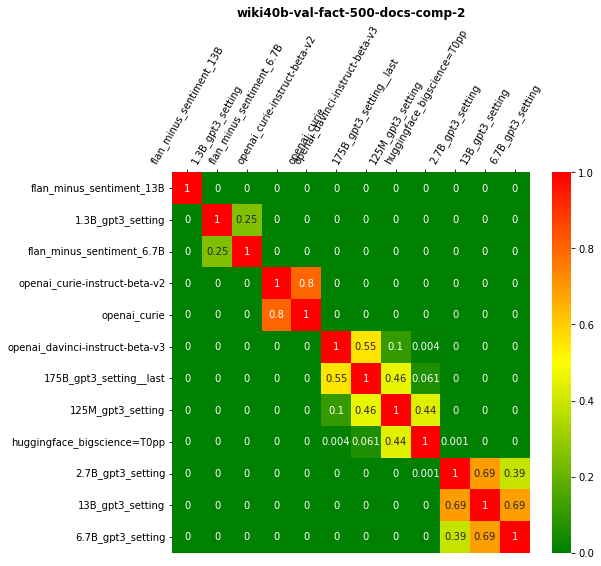

In [29]:
figure(figsize=(8, 7))

significance_matrix = np.around(sig_pt, 3)
ax = sns.heatmap(
    significance_matrix, 
#     mask=sig_matrix_mask, 
    xticklabels=df3.model_name.to_list(),
    yticklabels=df3.model_name.to_list(),
    vmin=0.00,
    vmax=1,  # 0.3
    annot=True,
    cmap=cmap_green_yellow_red
)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title(df3.eval_set.to_list()[0], weight='bold')

plt.show()

In [30]:
sig_bt1 = sig_bt
np.sum(np.array(sig_pt) > 0.1)

30

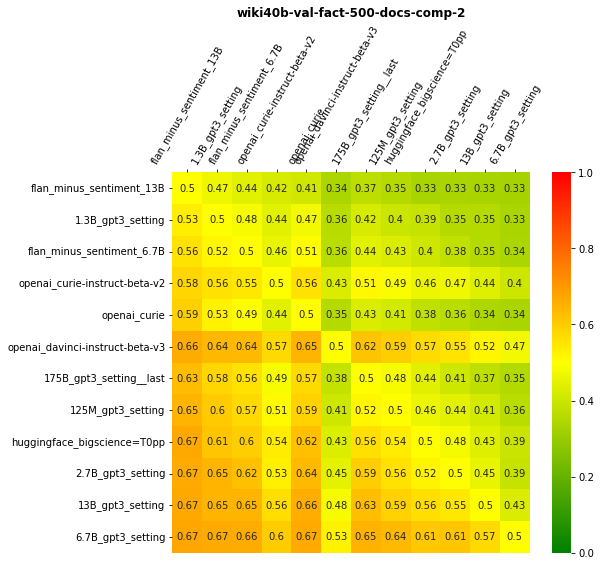

In [31]:
figure(figsize=(8, 7))

significance_matrix = np.around(results_bt, 3)
ax = sns.heatmap(
    significance_matrix, 
#     mask=sig_matrix_mask, 
    xticklabels=df3.model_name.to_list(),
    yticklabels=df3.model_name.to_list(),
    vmin=0.00,
    vmax=1,  # 0.3
    annot=True,
    cmap=cmap_green_yellow_red
)
plt.yticks(rotation=0)
ax.tick_params(axis='x', rotation=60)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_title(df3.eval_set.to_list()[0], weight='bold')

plt.show()

## Check the inconsist significance test result from BT and accuracy

* Model pairs which are insignificantly different by BT score (most are significant)

In [32]:
df3 = df3.sort_values(by=["bt"])
mns1 = df3.reset_index().model_name
ss = set([(mns1[x[0]] + ' ' + mns1[x[1]]) 
     for x in zip(np.where(np.array(sig_bt1) > 0.1)[0], np.where(np.array(sig_bt1) > 0.1)[1])
     if x[0] > x[1]])
ss

{'125M_gpt3_setting flan_minus_sentiment_6.7B',
 '13B_gpt3_setting 2.7B_gpt3_setting',
 '175B_gpt3_setting__last 1.3B_gpt3_setting',
 '175B_gpt3_setting__last openai_curie',
 '6.7B_gpt3_setting openai_curie-instruct-beta-v2',
 'huggingface_bigscience=T0pp 125M_gpt3_setting',
 'huggingface_bigscience=T0pp flan_minus_sentiment_6.7B',
 'openai_curie 1.3B_gpt3_setting',
 'openai_davinci-instruct-beta-v3 openai_curie-instruct-beta-v2'}

* Model pairs which are insignificantly different by accuracy (most are significant)

In [33]:
df3 = df3.sort_values(by=["_metric_val"])
mns = df3.reset_index().model_name
s1 = set([(mns[x[0]] + ' ' + mns[x[1]])
     for x in zip(np.where(np.array(sig_pt) > 0.1)[0], np.where(np.array(sig_pt) > 0.1)[1])
     if x[0] > x[1]])
s1

{'125M_gpt3_setting 175B_gpt3_setting__last',
 '125M_gpt3_setting openai_davinci-instruct-beta-v3',
 '13B_gpt3_setting 2.7B_gpt3_setting',
 '175B_gpt3_setting__last openai_davinci-instruct-beta-v3',
 '6.7B_gpt3_setting 13B_gpt3_setting',
 '6.7B_gpt3_setting 2.7B_gpt3_setting',
 'flan_minus_sentiment_6.7B 1.3B_gpt3_setting',
 'huggingface_bigscience=T0pp 125M_gpt3_setting',
 'openai_curie openai_curie-instruct-beta-v2'}

In [34]:
print(f"\n{len((ss).union(s1))} pairs are insignificant in either tests ({len((ss).union(s1))/(df3.shape[0]**2-df3.shape[0])*100:.2f}% of all pairs):")
(ss - s1).union(s1 - ss)


16 pairs are insignificant in either tests (12.12% of all pairs):


{'125M_gpt3_setting 175B_gpt3_setting__last',
 '125M_gpt3_setting flan_minus_sentiment_6.7B',
 '125M_gpt3_setting openai_davinci-instruct-beta-v3',
 '175B_gpt3_setting__last 1.3B_gpt3_setting',
 '175B_gpt3_setting__last openai_curie',
 '175B_gpt3_setting__last openai_davinci-instruct-beta-v3',
 '6.7B_gpt3_setting 13B_gpt3_setting',
 '6.7B_gpt3_setting 2.7B_gpt3_setting',
 '6.7B_gpt3_setting openai_curie-instruct-beta-v2',
 'flan_minus_sentiment_6.7B 1.3B_gpt3_setting',
 'huggingface_bigscience=T0pp flan_minus_sentiment_6.7B',
 'openai_curie 1.3B_gpt3_setting',
 'openai_curie openai_curie-instruct-beta-v2',
 'openai_davinci-instruct-beta-v3 openai_curie-instruct-beta-v2'}

In [35]:
print(f"\nOnly {len((ss).intersection(s1))} pairs are insignificant in both tests ({len((ss).intersection(s1))/len((ss).union(s1))*100:.2f}% of all insignificant pairs):")
(ss).intersection(s1)


Only 2 pairs are insignificant in both tests (12.50% of all insignificant pairs):


{'13B_gpt3_setting 2.7B_gpt3_setting',
 'huggingface_bigscience=T0pp 125M_gpt3_setting'}

* using paired signicance test results by BT scores and accuracy are ~88% consistent with each other
* but most pairs (87%) that are detected as insignificantly different are not suggested by both
* this suggests that using BT is not obviously better than using accuracy for this use case, but it may serve as a secondary metric for multi-pair system comparison
* further analysis may be needed on the metrics in the future
